## Original Model 4 Qubits

In [18]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4):  # Increased depth
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6  # Increased parameters per qubit
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params
    
    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit"""
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
        
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
        
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        # Use top 2 eigenvectors with proper weighting
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices] / np.sum(eigenvals[top_indices])
        latent_state = np.sum([w * eigenvecs[:, i] for w, i in zip(weights, top_indices)], axis=0)
        return latent_state / np.linalg.norm(latent_state)
    
    def forward(self, x):
        """Forward pass"""
        encoded = self.encoder(x, self.params)
        latent = self.get_latent_state(encoded)
        decoded = self.decoder(latent, self.params)
        return decoded

def preprocess_data(X):
    """Enhanced data preprocessing"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Additional normalization step
    X_scaled = X_scaled / np.max(np.abs(X_scaled))
    return X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]

def train_model(n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process"""
    set_seeds(seed)
    
    # Generate better synthetic data
    n_features = 16
    X, y = make_classification(
        n_samples=200,
        n_features=n_features,
        n_classes=2,
        n_informative=6,
        n_redundant=0,
        n_clusters_per_class=2,
        class_sep=2.5,  # Increased class separation
        random_state=seed
    )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    latent_qubits = n_qubits - 1
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10  # Increased patience
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-" * 50)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            for x in batch_data:
                decoded = model.forward(x)
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                # Enhanced loss calculation
                reconstruction_loss = torch.mean((decoded - x_tensor)**2)
                l2_reg = 0.0001 * torch.sum(params**2)  # Reduced L2 regularization
                loss = reconstruction_loss + l2_reg
                
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)
        
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.95 and train_accuracy >= 0.95:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics

if __name__ == "__main__":
    SEED = 42
    set_seeds(SEED)
    
    model, best_accuracy, metrics = train_model(seed=SEED)
    
    print(f"\nTraining Summary (Seed={SEED}):")
    print(f"Initial Training Accuracy: {metrics['train_accuracies'][0]:.4f}")
    print(f"Final Training Accuracy: {metrics['train_accuracies'][-1]:.4f}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    
    train_acc_std = np.std(metrics['train_accuracies'])
    val_acc_std = np.std(metrics['val_accuracies'])
    print(f"\nStability Metrics:")
    print(f"Training Accuracy Std: {train_acc_std:.4f}")
    print(f"Validation Accuracy Std: {val_acc_std:.4f}")


Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------


C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\2922944290.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)


    0 | 0.1113 | 0.8999 | 0.0943 | 0.9138
    1 | 0.1038 | 0.9060 | 0.0961 | 0.9123
    2 | 0.1036 | 0.9061 | 0.0935 | 0.9145
    3 | 0.1029 | 0.9067 | 0.0928 | 0.9150
    4 | 0.1048 | 0.9051 | 0.0943 | 0.9138
    5 | 0.1029 | 0.9067 | 0.0937 | 0.9143
    6 | 0.1003 | 0.9089 | 0.0937 | 0.9143
    7 | 0.1037 | 0.9061 | 0.0933 | 0.9147
    8 | 0.1005 | 0.9086 | 0.0925 | 0.9154
    9 | 0.0964 | 0.9121 | 0.0915 | 0.9162
   10 | 0.0987 | 0.9102 | 0.0915 | 0.9161
   11 | 0.0977 | 0.9110 | 0.0915 | 0.9161
   12 | 0.0976 | 0.9111 | 0.0898 | 0.9176
   13 | 0.0987 | 0.9102 | 0.0902 | 0.9173
   14 | 0.0955 | 0.9128 | 0.0913 | 0.9163
   15 | 0.0930 | 0.9149 | 0.0920 | 0.9158
   16 | 0.0997 | 0.9093 | 0.0929 | 0.9150
   17 | 0.0954 | 0.9129 | 0.0944 | 0.9137
   18 | 0.0933 | 0.9147 | 0.0965 | 0.9120
   19 | 0.0971 | 0.9115 | 0.0981 | 0.9107
   20 | 0.0942 | 0.9139 | 0.0989 | 0.9100
   21 | 0.0939 | 0.9142 | 0.0992 | 0.9098
   22 | 0.0927 | 0.9152 | 0.1002 | 0.9089

Early stopping triggered!

Traini

## Pruned Model

In [20]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class PrunedQuantumAutoencoder(QuantumAutoencoder):
    def __init__(self, n_qubits, latent_qubits, depth=3, entropy_threshold=0.1):
        super().__init__(n_qubits, latent_qubits, depth)
        self.entropy_threshold = entropy_threshold
        self.active_qubits = list(range(n_qubits))

    def calculate_von_neumann_entropy(self, state):
        """Calculate Von Neumann entropy for each qubit"""
        if torch.is_tensor(state):
            state = state.detach().numpy()
        
        state_matrix = np.outer(state, np.conjugate(state))
        n_qubits = int(np.log2(len(state)))
        entropies = []
        
        for i in range(n_qubits):
            reduced_matrix = self._partial_trace(state_matrix, i, n_qubits)
            eigenvalues = np.real(np.linalg.eigvals(reduced_matrix))
            eigenvalues = eigenvalues[eigenvalues > 1e-10]
            entropy = -np.sum(eigenvalues * np.log2(eigenvalues + 1e-10))
            entropies.append(entropy)
            
        return np.array(entropies)

    def _partial_trace(self, density_matrix, target_qubit, n_qubits):
        """Compute partial trace over all qubits except target"""
        dim = 2**n_qubits
        reduced_dim = 2
        reduced_matrix = np.zeros((reduced_dim, reduced_dim), dtype=complex)
        
        for i in range(reduced_dim):
            for j in range(reduced_dim):
                sum_val = 0
                for k in range(dim//(2**(target_qubit + 1))):
                    for l in range(2**target_qubit):
                        idx1 = k * 2**(target_qubit + 1) + l + i * 2**target_qubit
                        idx2 = k * 2**(target_qubit + 1) + l + j * 2**target_qubit
                        sum_val += density_matrix[idx1, idx2]
                reduced_matrix[i, j] = sum_val
                
        return reduced_matrix

    def _encoder_circuit(self, data, params):
        """Modified encoder circuit for active qubits"""
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True)
        
        param_idx = 0
        for d in range(self.depth):
            # Apply rotations only to active qubits
            for i in self.active_qubits:
                qml.RX(params[param_idx], wires=i)
                qml.RY(params[param_idx + 1], wires=i)
                qml.RZ(params[param_idx + 2], wires=i)
                param_idx += 3
            
            # Entangling gates between active qubits
            for i in range(len(self.active_qubits) - 1):
                qml.CNOT(wires=[self.active_qubits[i], self.active_qubits[i + 1]])
        
        return qml.state()

    def _decoder_circuit(self, latent_state, params):
        """Modified decoder circuit for active qubits"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
        
        # Initialize non-latent active qubits
        for i in self.active_qubits[self.latent_qubits:]:
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
        
        param_idx = self.n_params // 2
        for d in range(self.depth):
            # Apply rotations only to active qubits
            for i in self.active_qubits:
                qml.RX(params[param_idx], wires=i)
                qml.RY(params[param_idx + 1], wires=i)
                qml.RZ(params[param_idx + 2], wires=i)
                param_idx += 3
            
            # Entangling gates between active qubits
            for i in range(len(self.active_qubits) - 1):
                qml.CNOT(wires=[self.active_qubits[i], self.active_qubits[i + 1]])
        
        return qml.state()

    def prune_qubits(self, encoded_state):
        """Prune qubits based on entropy threshold"""
        entropies = self.calculate_von_neumann_entropy(encoded_state)
        keep_qubits = [i for i, entropy in enumerate(entropies) 
                      if entropy >= self.entropy_threshold]
        
        if len(keep_qubits) < self.latent_qubits:
            top_indices = np.argsort(entropies)[-self.latent_qubits:]
            keep_qubits = sorted(list(top_indices))
        
        self.active_qubits = keep_qubits
        return keep_qubits, entropies

def train_pruned_model(n_epochs=50, batch_size=8, entropy_threshold=0.1):
    """Training procedure with entropy-based pruning"""
    n_features = 16
    X, y = make_classification(
        n_samples=200,
        n_features=n_features,
        n_classes=2,
        n_informative=6,
        n_redundant=0,
        n_clusters_per_class=2,
        class_sep=2.0,
        random_state=42
    )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    latent_qubits = n_qubits - 1
    model = PrunedQuantumAutoencoder(
        n_qubits=n_qubits,
        latent_qubits=latent_qubits,
        depth=3,
        entropy_threshold=entropy_threshold
    )
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.002)
    
    print("Starting training with entropy-based pruning...")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Active Qubits")
    print("-" * 70)
    
    start_time = time.time()
    best_loss = float('inf')
    best_params = None
    patience = 10
    patience_counter = 0
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            
            for x in batch_data:
                # Forward pass with entropy-based pruning
                encoded = model.encoder(x, model.params)
                
                # Perform pruning every 5 epochs
                if epoch % 5 == 0:
                    keep_qubits, entropies = model.prune_qubits(encoded)
                    print(f"\nQubit entropies: {entropies}")
                    print(f"Active qubits: {keep_qubits}")
                
                latent = model.get_latent_state(encoded)
                decoded = model.decoder(latent, model.params)
                
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float32, requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                loss = torch.mean((decoded - x_tensor)**2)
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | "
              f"{val_accuracy:.4f} | {len(model.active_qubits)}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
    
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    # Final metrics
    print("\nFinal Results:")
    print(f"Final Training Accuracy: {train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")
    print(f"Initial qubits: {n_qubits}")
    print(f"Final active qubits: {len(model.active_qubits)}")
    print(f"Qubit reduction: {(n_qubits - len(model.active_qubits))/n_qubits*100:.1f}%")
    
    model.params = best_params.numpy()
    return model, val_accuracy

if __name__ == "__main__":
    # Train with different entropy thresholds
    thresholds = [0.1, 0.2, 0.3]
    results = {}
    
    for threshold in thresholds:
        print(f"\nTraining with entropy threshold = {threshold}")
        model, accuracy = train_pruned_model(entropy_threshold=threshold)
        results[threshold] = {
            'accuracy': accuracy,
            'active_qubits': len(model.active_qubits)
        }
    
    # Compare results
    print("\nThreshold Comparison:")
    print("Threshold | Accuracy | Active Qubits")
    print("-" * 35)
    for threshold, res in results.items():
        print(f"{threshold:9.1f} | {res['accuracy']:.4f} | {res['active_qubits']:12d}")


Training with entropy threshold = 0.1
Starting training with entropy-based pruning...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Active Qubits
----------------------------------------------------------------------

Qubit entropies: [0.94202222 0.71333548 0.91078293 0.87074387]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.93940495 0.97991315 0.86258393 0.91754969]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.81127328 0.83479249 0.85892177 0.73460767]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.89627717 0.90083873 0.96022709 0.97187809]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.93337884 0.99351135 0.40723491 0.86643281]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.8466558  0.87184706 0.81341268 0.6901902 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.93980283 0.79498249 0.8480508  0.92728793]
Active qubits: [0, 1, 2, 3]


C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\1259345169.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float32, requires_grad=True)



Qubit entropies: [0.5414718  0.7363691  0.7274358  0.77328854]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.94202222 0.71333548 0.91078293 0.87074387]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.8668942  0.83190769 0.8932078  0.86231655]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.97826887 0.86955801 0.98138862 0.97621126]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.88949468 0.83701776 0.86880481 0.83700347]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.85292633 0.83191264 0.82252537 0.65614793]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.8034512  0.95497253 0.75134221 0.8849051 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.9249315  0.84174464 0.65521603 0.94832762]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.91680487 0.97005355 0.97434375 0.8292386 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.85495529 0.92774255 0.91390208 0.87005875]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.85292633 0.83191264 0.82252537 0.65614793]
Active qubits: [

C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\1259345169.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float32, requires_grad=True)



Qubit entropies: [0.85174557 0.97779283 0.86939992 0.86601763]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.95729516 0.98988535 0.96231991 0.8705791 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.71758977 0.78408929 0.87448947 0.93923291]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.92001359 0.98210745 0.97239795 0.85090122]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.84561871 0.88962434 0.77971914 0.93140224]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.84561871 0.88962434 0.77971914 0.93140224]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.94141003 0.91996688 0.94302369 0.85089704]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.6473883  0.81090791 0.81836678 0.77429863]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.85213644 0.95807799 0.73613223 0.9207005 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.97587871 0.92192182 0.96339122 0.73174739]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.90629391 0.96334196 0.97166986 0.93557161]
Active qubits: [

C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\1259345169.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float32, requires_grad=True)



Qubit entropies: [0.80631851 0.8376404  0.94523194 0.9205819 ]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.86467251 0.97874642 0.93596732 0.89378958]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.93690226 0.9013807  0.98420378 0.95216526]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.78407919 0.92162181 0.81428658 0.88780545]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.91522513 0.89520734 0.85588255 0.91103785]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.82814041 0.98104693 0.88390413 0.80295217]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.93671466 0.90254491 0.89622413 0.90984276]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.92706996 0.77154899 0.99412969 0.91750666]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.86103372 0.88875242 0.92985969 0.66931021]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.973879   0.75542443 0.92555453 0.76274386]
Active qubits: [0, 1, 2, 3]

Qubit entropies: [0.83435054 0.87232363 0.81207437 0.79721764]
Active qubits: [

## Visualizations 

In [22]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

class PrunedQuantumAutoencoder(QuantumAutoencoder):
    def __init__(self, n_qubits, latent_qubits, depth=4, entropy_threshold=0.1):
        super().__init__(n_qubits, latent_qubits, depth)
        self.entropy_threshold = entropy_threshold
        self.active_qubits = list(range(n_qubits))
        
    def calculate_von_neumann_entropy(self, state):
        """Calculate Von Neumann entropy for each qubit"""
        if torch.is_tensor(state):
            state = state.detach().numpy()
        
        state_matrix = np.outer(state, np.conjugate(state))
        n_qubits = int(np.log2(len(state)))
        entropies = []
        
        for i in range(n_qubits):
            # Calculate reduced density matrix for qubit i
            reduced_matrix = self._partial_trace(state_matrix, i, n_qubits)
            # Calculate eigenvalues
            eigenvalues = np.real(np.linalg.eigvals(reduced_matrix))
            # Filter near-zero eigenvalues
            eigenvalues = eigenvalues[eigenvalues > 1e-10]
            # Calculate Von Neumann entropy
            entropy = -np.sum(eigenvalues * np.log2(eigenvalues + 1e-10))
            entropies.append(entropy)
            
        return np.array(entropies)

    def _partial_trace(self, density_matrix, target_qubit, n_qubits):
        """Compute partial trace over all qubits except target"""
        dim = 2**n_qubits
        reduced_dim = 2
        reduced_matrix = np.zeros((reduced_dim, reduced_dim), dtype=complex)
        
        for i in range(reduced_dim):
            for j in range(reduced_dim):
                sum_val = 0
                for k in range(dim//(2**(target_qubit + 1))):
                    for l in range(2**target_qubit):
                        idx1 = k * 2**(target_qubit + 1) + l + i * 2**target_qubit
                        idx2 = k * 2**(target_qubit + 1) + l + j * 2**target_qubit
                        sum_val += density_matrix[idx1, idx2]
                reduced_matrix[i, j] = sum_val
                
        return reduced_matrix

    def _encoder_circuit(self, data, params):
        """Modified encoder circuit with entropy-based pruning"""
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True)
        
        param_idx = 0
        for d in range(self.depth):
            # Apply rotations only to active qubits
            for i in self.active_qubits:
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Modified entangling structure for active qubits
            active_pairs = [(i, j) for i, j in zip(self.active_qubits[:-1], 
                                                  self.active_qubits[1:])]
            for i, j in active_pairs:
                qml.CRZ(params[param_idx % self.n_params], wires=[i, j])
                qml.CNOT(wires=[i, j])
            
            if len(self.active_qubits) > 2:
                for i in range(0, len(self.active_qubits) - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], 
                           wires=[self.active_qubits[i], self.active_qubits[i + 2]])
                    qml.CNOT(wires=[self.active_qubits[i], self.active_qubits[i + 2]])
        
        return qml.state()

    def _decoder_circuit(self, latent_state, params):
        """Modified decoder circuit with entropy-based pruning"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
        
        # Initialize remaining active qubits
        for i in self.active_qubits[self.latent_qubits:]:
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
        
        param_idx = self.n_params // 2
        for d in range(self.depth):
            # Apply rotations only to active qubits
            for i in self.active_qubits:
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Modified entangling structure for active qubits
            active_pairs = [(i, j) for i, j in zip(self.active_qubits[:-1], 
                                                  self.active_qubits[1:])]
            for i, j in active_pairs:
                qml.CRZ(params[param_idx % self.n_params], wires=[i, j])
                qml.CNOT(wires=[i, j])
            
            if len(self.active_qubits) > 2:
                for i in range(0, len(self.active_qubits) - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], 
                           wires=[self.active_qubits[i], self.active_qubits[i + 2]])
                    qml.CNOT(wires=[self.active_qubits[i], self.active_qubits[i + 2]])
        
        return qml.state()

    def prune_qubits(self, encoded_state):
        """Prune qubits based on entropy threshold"""
        entropies = self.calculate_von_neumann_entropy(encoded_state)
        
        # Identify high-entropy qubits
        keep_qubits = [i for i, entropy in enumerate(entropies) 
                      if entropy >= self.entropy_threshold]
        
        # Ensure minimum number of qubits for latent space
        if len(keep_qubits) < self.latent_qubits:
            # Keep top entropy qubits if below minimum
            top_indices = np.argsort(entropies)[-self.latent_qubits:]
            keep_qubits = sorted(list(top_indices))
        
        self.active_qubits = keep_qubits
        return keep_qubits, entropies

def train_pruned_model(n_epochs=100, batch_size=4, learning_rate=0.002, 
                      entropy_threshold=0.1, seed=42):
    """Training process with entropy-based pruning"""
    set_seeds(seed)
    
    # Generate synthetic data
    n_features = 16
    X, y = make_classification(
        n_samples=200,
        n_features=n_features,
        n_classes=2,
        n_informative=6,
        n_redundant=0,
        n_clusters_per_class=2,
        class_sep=2.5,
        random_state=seed
    )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    latent_qubits = n_qubits - 1
    model = PrunedQuantumAutoencoder(
        n_qubits=n_qubits,
        latent_qubits=latent_qubits,
        entropy_threshold=entropy_threshold
    )
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {
        'train_losses': [], 
        'train_accuracies': [], 
        'val_losses': [], 
        'val_accuracies': [],
        'active_qubits': [],
        'entropies': []
    }
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Active Qubits")
    print("-" * 70)
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            
            for x in batch_data:
                # Forward pass with pruning
                encoded = model.encoder(x, model.params)
                
                # Perform pruning every 5 epochs
                if epoch % 5 == 0:
                    keep_qubits, entropies = model.prune_qubits(encoded)
                    metrics['entropies'].append(entropies)
                
                latent = model.get_latent_state(encoded)
                decoded = model.decoder(latent, model.params)
                
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64, 
                                    requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                reconstruction_loss = torch.mean((decoded - x_tensor)**2)
                l2_reg = 0.0001 * torch.sum(params**2)
                loss = reconstruction_loss + l2_reg
                
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)
        
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        metrics['active_qubits'].append(len(model.active_qubits))
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | "
              f"{val_loss:.4f} | {val_accuracy:.4f} | {len(model.active_qubits):12d}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.95 and train_accuracy >= 0.95:
            print("\nTarget accuracy achieved!")
            break
    
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print("\nPruning Results:")
    print(f"Initial qubits: {n_qubits}")
    print(f"Final active qubits: {len(model.active_qubits)}")
    print(f"Qubit reduction: {(n_qubits - len(model.active_qubits))/n_qubits*100:.1f}%")
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics

if __name__ == "__main__":
    model, best_accuracy, metrics = train_pruned_model(entropy_threshold=0.1)


Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Active Qubits
----------------------------------------------------------------------


C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\3780363649.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float64,


    0 | 0.1113 | 0.8999 | 0.0943 | 0.9138 |            4
    1 | 0.1038 | 0.9060 | 0.0961 | 0.9123 |            4
    2 | 0.1036 | 0.9061 | 0.0935 | 0.9145 |            4
    3 | 0.1029 | 0.9067 | 0.0928 | 0.9150 |            4
    4 | 0.1048 | 0.9051 | 0.0943 | 0.9138 |            4
    5 | 0.1029 | 0.9067 | 0.0937 | 0.9143 |            4
    6 | 0.1003 | 0.9089 | 0.0937 | 0.9143 |            4
    7 | 0.1037 | 0.9061 | 0.0933 | 0.9147 |            4
    8 | 0.1005 | 0.9086 | 0.0925 | 0.9154 |            4
    9 | 0.0964 | 0.9121 | 0.0915 | 0.9162 |            4
   10 | 0.0987 | 0.9102 | 0.0915 | 0.9161 |            4
   11 | 0.0977 | 0.9110 | 0.0915 | 0.9161 |            4
   12 | 0.0976 | 0.9111 | 0.0898 | 0.9176 |            4
   13 | 0.0987 | 0.9102 | 0.0902 | 0.9173 |            4
   14 | 0.0955 | 0.9128 | 0.0913 | 0.9163 |            4
   15 | 0.0930 | 0.9149 | 0.0920 | 0.9158 |            4
   16 | 0.0997 | 0.9093 | 0.0929 | 0.9150 |            4
   17 | 0.0954 | 0.9129 | 0.094


Training Progress with Metrics:
Epoch | Train Time | Infer Time | Memory (MB) | Active Qubits | Accuracy
---------------------------------------------------------------------------


C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\899966600.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float32,


    0 |      8.37 |      1.98 |        0.0 |            4 | 0.9146
    1 |      8.21 |      1.98 |        0.0 |            4 | 0.9146
    2 |      7.85 |      1.82 |        0.0 |            4 | 0.9146
    3 |      8.27 |      1.95 |        0.0 |            4 | 0.9146
    4 |      8.02 |      1.84 |        0.0 |            4 | 0.9146
    5 |      8.12 |      1.79 |        0.8 |            4 | 0.9146
    6 |      7.47 |      1.82 |        0.0 |            4 | 0.9146
    7 |      7.66 |      2.07 |        0.0 |            4 | 0.9146
    8 |      7.83 |      1.92 |        0.0 |            4 | 0.9146
    9 |      7.51 |      1.87 |        0.0 |            4 | 0.9146
   10 |      8.09 |      1.84 |        0.0 |            4 | 0.9146
   11 |      7.34 |      1.83 |        0.0 |            4 | 0.9146
   12 |      7.89 |      1.98 |        0.0 |            4 | 0.9146
   13 |      7.60 |      2.22 |        0.0 |            4 | 0.9146
   14 |      7.80 |      1.80 |        0.0 |            4 | 0.

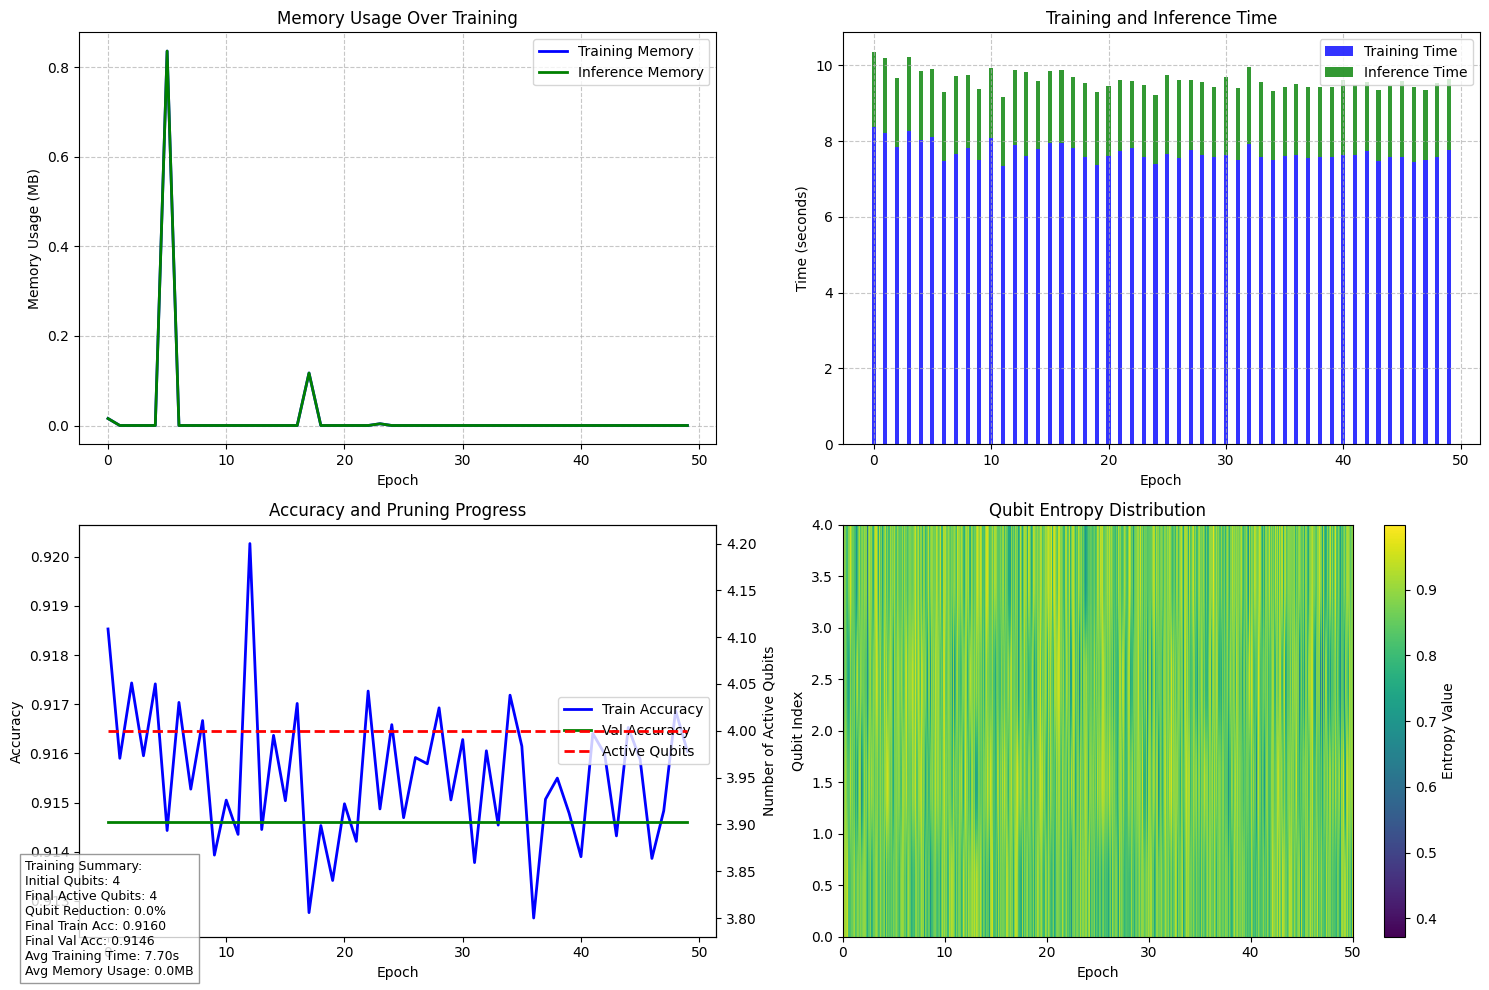


Training Summary:
Initial Qubits: 4
Final Active Qubits: 4
Qubit Reduction: 0.0%
Final Training Accuracy: 0.9160
Final Validation Accuracy: 0.9146


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil

def plot_pruning_metrics(metrics):
    """Plot performance metrics for pruned QAE"""
    plt.rcParams['figure.figsize'] = [15, 10]
    
    fig = plt.figure()
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Memory Usage Plot (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    epochs = metrics['epochs']
    training_mem = metrics['train_memory']
    inference_mem = metrics['inference_memory']
    
    ax1.plot(epochs, training_mem, 'b-', label='Training Memory', linewidth=2)
    ax1.plot(epochs, inference_mem, 'g-', label='Inference Memory', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Memory Usage (MB)')
    ax1.set_title('Memory Usage Over Training')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 2. Training Time Plot (Top Right)
    ax2 = fig.add_subplot(gs[0, 1])
    training_time = metrics['train_time']
    inference_time = metrics['inference_time']
    
    ax2.bar(epochs, training_time, width=0.35, label='Training Time', 
            alpha=0.8, color='blue')
    ax2.bar(epochs, inference_time, width=0.35, bottom=training_time, 
            label='Inference Time', alpha=0.8, color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Training and Inference Time')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 3. Accuracy and Active Qubits (Bottom Left)
    ax3 = fig.add_subplot(gs[1, 0])
    train_acc = metrics['train_accuracies']
    val_acc = metrics['val_accuracies']
    active_qubits = metrics['active_qubits']
    
    ax3_twin = ax3.twinx()
    
    # Plot accuracies on left axis
    ln1 = ax3.plot(epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
    ln2 = ax3.plot(epochs, val_acc, 'g-', label='Val Accuracy', linewidth=2)
    
    # Plot active qubits on right axis
    ln3 = ax3_twin.plot(epochs, active_qubits, 'r--', 
                       label='Active Qubits', linewidth=2)
    
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3_twin.set_ylabel('Number of Active Qubits')
    ax3.set_title('Accuracy and Pruning Progress')
    
    # Combine legends
    lns = ln1 + ln2 + ln3
    labs = [l.get_label() for l in lns]
    ax3.legend(lns, labs, loc='center right')
    
    # 4. Entropy Distribution (Bottom Right)
    ax4 = fig.add_subplot(gs[1, 1])
    
    if 'entropy_history' in metrics and metrics['entropy_history']:
        entropy_data = np.array(metrics['entropy_history'])
        epochs_with_pruning = range(0, len(epochs), 5)  # Every 5th epoch
        
        im = ax4.imshow(entropy_data.T, aspect='auto', cmap='viridis',
                       extent=[0, len(epochs), 0, entropy_data.shape[1]])
        plt.colorbar(im, ax=ax4, label='Entropy Value')
        
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Qubit Index')
        ax4.set_title('Qubit Entropy Distribution')
    
    plt.tight_layout()
    
    # Add summary statistics
    summary_text = (
        f"Training Summary:\n"
        f"Initial Qubits: {metrics['initial_qubits']}\n"
        f"Final Active Qubits: {metrics['active_qubits'][-1]}\n"
        f"Qubit Reduction: {(metrics['initial_qubits'] - metrics['active_qubits'][-1])/metrics['initial_qubits']*100:.1f}%\n"
        f"Final Train Acc: {metrics['train_accuracies'][-1]:.4f}\n"
        f"Final Val Acc: {metrics['val_accuracies'][-1]:.4f}\n"
        f"Avg Training Time: {np.mean(metrics['train_time']):.2f}s\n"
        f"Avg Memory Usage: {np.mean(metrics['train_memory']):.1f}MB"
    )
    
    plt.figtext(0.02, 0.02, summary_text, fontsize=9,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
    
    return fig

def train_pruned_model_with_metrics(n_epochs=50, batch_size=8, entropy_threshold=0.1):
    """Training procedure with comprehensive metrics tracking"""
    metrics = {
        'epochs': [],
        'train_memory': [],
        'inference_memory': [],
        'train_time': [],
        'inference_time': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'active_qubits': [],
        'entropy_history': [],
        'initial_qubits': 0
    }
    
    # Data preparation and model initialization
    n_features = 16
    X, y = make_classification(n_samples=200, n_features=n_features,
                             n_classes=2, n_informative=6, random_state=42)
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    metrics['initial_qubits'] = n_qubits
    
    model = PrunedQuantumAutoencoder(n_qubits=n_qubits,
                                   latent_qubits=n_qubits-1,
                                   entropy_threshold=entropy_threshold)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.002)
    
    print("\nTraining Progress with Metrics:")
    print("Epoch | Train Time | Infer Time | Memory (MB) | Active Qubits | Accuracy")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        # Training phase
        train_start = time.time()
        initial_mem = psutil.Process().memory_info().rss / 1024 / 1024
        
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            
            for x in batch_data:
                # Forward pass with pruning
                encoded = model.encoder(x, model.params)
                
                if epoch % 5 == 0:
                    keep_qubits, entropies = model.prune_qubits(encoded)
                    metrics['entropy_history'].append(entropies)
                
                latent = model.get_latent_state(encoded)
                decoded = model.decoder(latent, model.params)
                
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float32, 
                                    requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                loss = torch.mean((decoded - x_tensor)**2)
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_time = time.time() - train_start
        train_mem = psutil.Process().memory_info().rss / 1024 / 1024 - initial_mem
        
        # Inference phase
        inference_start = time.time()
        val_losses = []
        
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        inference_time = time.time() - inference_start
        inference_mem = psutil.Process().memory_info().rss / 1024 / 1024 - initial_mem
        
        # Calculate metrics
        train_loss = epoch_loss / n_batches
        val_loss = np.mean(val_losses)
        train_accuracy = 1 / (1 + train_loss)
        val_accuracy = 1 / (1 + val_loss)
        
        # Store metrics
        metrics['epochs'].append(epoch)
        metrics['train_memory'].append(train_mem)
        metrics['inference_memory'].append(inference_mem)
        metrics['train_time'].append(train_time)
        metrics['inference_time'].append(inference_time)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_accuracies'].append(val_accuracy)
        metrics['active_qubits'].append(len(model.active_qubits))
        
        print(f"{epoch:5d} | {train_time:9.2f} | {inference_time:9.2f} | "
              f"{train_mem:10.1f} | {len(model.active_qubits):12d} | {val_accuracy:.4f}")
    
    return model, metrics

if __name__ == "__main__":
    # Train model and collect metrics
    model, metrics = train_pruned_model_with_metrics()
    
    # Plot metrics
    fig = plot_pruning_metrics(metrics)
    plt.show()
    
    # Print final summary
    print("\nTraining Summary:")
    print(f"Initial Qubits: {metrics['initial_qubits']}")
    print(f"Final Active Qubits: {metrics['active_qubits'][-1]}")
    print(f"Qubit Reduction: {(metrics['initial_qubits'] - metrics['active_qubits'][-1])/metrics['initial_qubits']*100:.1f}%")
    print(f"Final Training Accuracy: {metrics['train_accuracies'][-1]:.4f}")
    print(f"Final Validation Accuracy: {metrics['val_accuracies'][-1]:.4f}")


Training Progress:
Epoch | Train Time | Infer Time | Memory (MB) | Accuracy
------------------------------------------------------------


C:\Users\Maurice\AppData\Local\Temp\ipykernel_26336\19755572.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = torch.tensor(np.real(decoded), dtype=torch.float32,


    0 |      7.74 |      1.85 |        0.3 | 0.9144
    1 |      7.66 |      1.85 |        0.0 | 0.9144
    2 |      7.63 |      1.83 |        0.0 | 0.9144
    3 |      7.62 |      1.98 |        0.0 | 0.9144
    4 |      7.49 |      1.98 |        0.0 | 0.9144
    5 |      7.60 |      1.99 |        0.0 | 0.9144
    6 |      7.63 |      1.84 |        0.0 | 0.9144
    7 |      7.62 |      1.84 |        0.0 | 0.9144
    8 |      7.62 |      1.85 |        0.0 | 0.9144
    9 |      7.60 |      1.88 |        0.0 | 0.9144
   10 |      7.58 |      1.90 |        0.0 | 0.9144
   11 |      7.57 |      2.00 |        0.0 | 0.9144
   12 |      7.45 |      2.04 |        0.0 | 0.9144
   13 |      7.54 |      1.84 |        0.0 | 0.9144
   14 |      7.79 |      1.86 |        0.0 | 0.9144
   15 |      7.61 |      1.85 |        0.0 | 0.9144
   16 |      7.60 |      1.88 |        0.0 | 0.9144
   17 |      7.58 |      1.84 |        0.0 | 0.9144
   18 |      7.63 |      1.83 |        0.0 | 0.9144
   19 |     

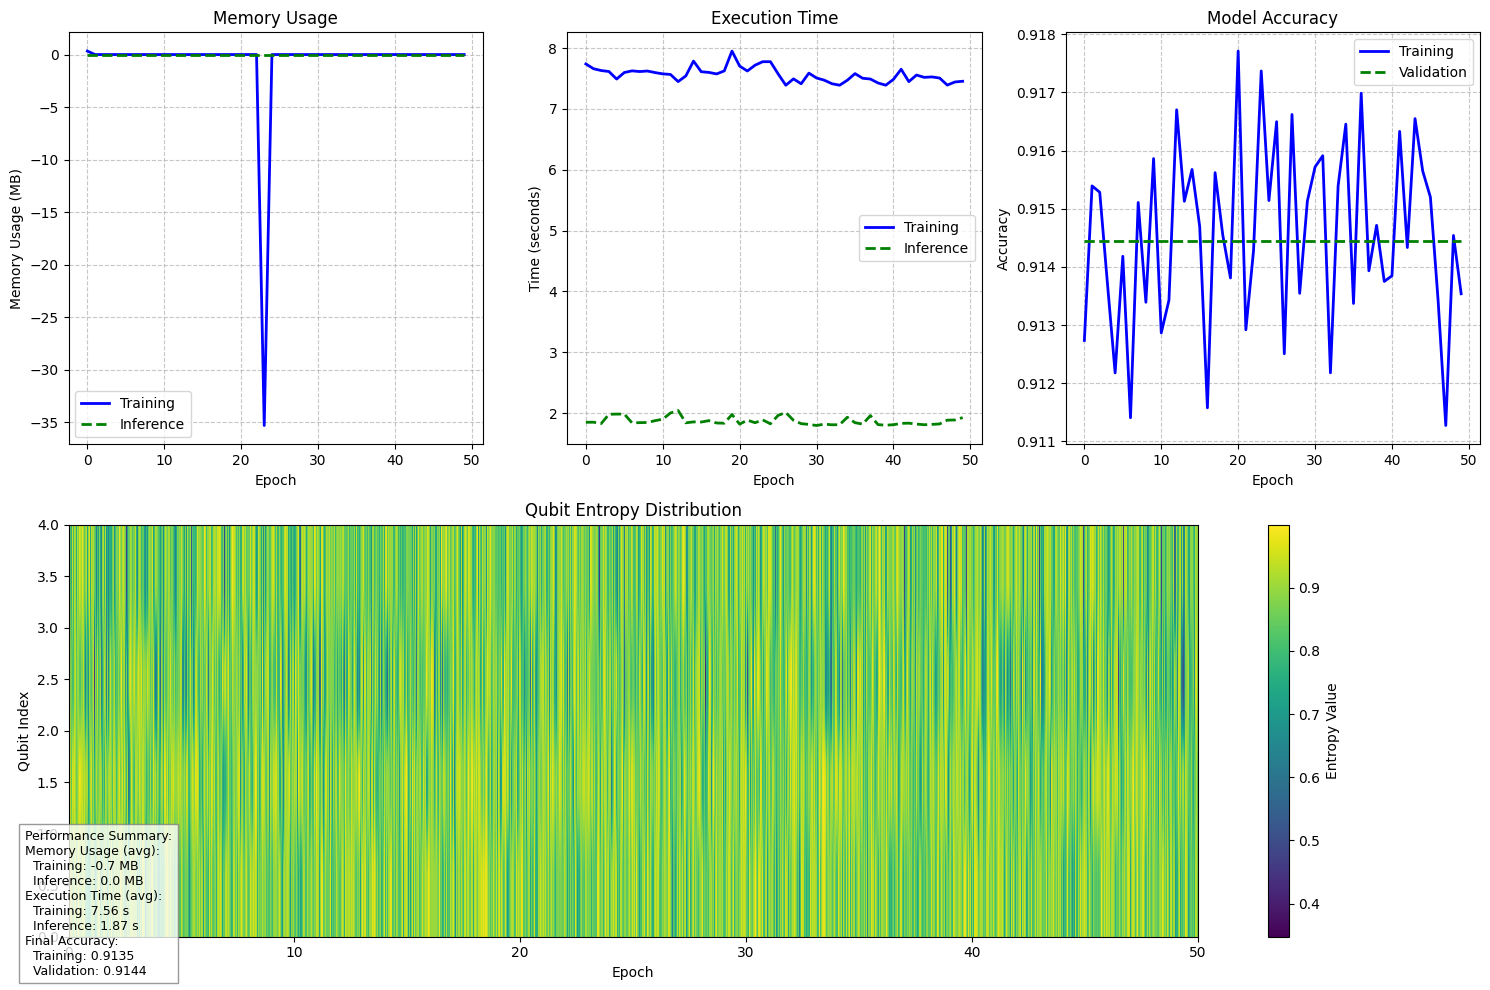


Final Performance Summary:
Average Training Memory: -0.7 MB
Average Inference Memory: 0.0 MB
Average Training Time: 7.56 s
Average Inference Time: 1.87 s
Final Training Accuracy: 0.9135
Final Validation Accuracy: 0.9144


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil

def plot_focused_metrics(metrics):
    """Plot focused set of metrics for pruned QAE"""
    plt.rcParams['figure.figsize'] = [15, 10]
    fig = plt.figure()
    gs = plt.GridSpec(2, 3, figure=fig)
    
    # 1. Memory Usage (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    epochs = metrics['epochs']
    training_mem = metrics['train_memory']
    inference_mem = metrics['inference_memory']
    
    ax1.plot(epochs, training_mem, 'b-', label='Training', linewidth=2)
    ax1.plot(epochs, inference_mem, 'g--', label='Inference', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Memory Usage (MB)')
    ax1.set_title('Memory Usage')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 2. Execution Time (Top Middle)
    ax2 = fig.add_subplot(gs[0, 1])
    train_time = metrics['train_time']
    inference_time = metrics['inference_time']
    
    ax2.plot(epochs, train_time, 'b-', label='Training', linewidth=2)
    ax2.plot(epochs, inference_time, 'g--', label='Inference', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Execution Time')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 3. Accuracy (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    train_acc = metrics['train_accuracies']
    val_acc = metrics['val_accuracies']
    
    ax3.plot(epochs, train_acc, 'b-', label='Training', linewidth=2)
    ax3.plot(epochs, val_acc, 'g--', label='Validation', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Model Accuracy')
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend()
    
    # 4. Entropy Distribution Heatmap (Bottom)
    ax4 = fig.add_subplot(gs[1, :])
    
    if 'entropy_history' in metrics and metrics['entropy_history']:
        entropy_data = np.array(metrics['entropy_history'])
        epochs_with_pruning = range(0, len(epochs), 5)  # Every 5th epoch
        
        im = ax4.imshow(entropy_data.T, aspect='auto', cmap='viridis',
                       extent=[0, len(epochs), 0, entropy_data.shape[1]])
        plt.colorbar(im, ax=ax4, label='Entropy Value')
        
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Qubit Index')
        ax4.set_title('Qubit Entropy Distribution')
    
    plt.tight_layout()
    
    # Add summary statistics
    summary_text = (
        f"Performance Summary:\n"
        f"Memory Usage (avg):\n"
        f"  Training: {np.mean(training_mem):.1f} MB\n"
        f"  Inference: {np.mean(inference_mem):.1f} MB\n"
        f"Execution Time (avg):\n"
        f"  Training: {np.mean(train_time):.2f} s\n"
        f"  Inference: {np.mean(inference_time):.2f} s\n"
        f"Final Accuracy:\n"
        f"  Training: {train_acc[-1]:.4f}\n"
        f"  Validation: {val_acc[-1]:.4f}"
    )
    
    plt.figtext(0.02, 0.02, summary_text, fontsize=9,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
    
    return fig

def train_with_focused_metrics(n_epochs=50, batch_size=8, entropy_threshold=0.1):
    """Training with focused metrics collection"""
    metrics = {
        'epochs': [],
        'train_memory': [],
        'inference_memory': [],
        'train_time': [],
        'inference_time': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'entropy_history': []
    }
    
    # Data preparation
    n_features = 16
    X, y = make_classification(
        n_samples=200, 
        n_features=n_features,
        n_classes=2, 
        n_informative=6, 
        random_state=42
    )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    # Model initialization
    n_qubits = int(np.log2(X_train.shape[1]))
    model = PrunedQuantumAutoencoder(
        n_qubits=n_qubits,
        latent_qubits=n_qubits-1,
        entropy_threshold=entropy_threshold
    )
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.002)
    
    print("\nTraining Progress:")
    print("Epoch | Train Time | Infer Time | Memory (MB) | Accuracy")
    print("-" * 60)
    
    for epoch in range(n_epochs):
        # Training phase
        train_start = time.time()
        initial_mem = psutil.Process().memory_info().rss / 1024 / 1024
        
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            
            for x in batch_data:
                # Forward pass with pruning
                encoded = model.encoder(x, model.params)
                
                # Track entropy every 5 epochs
                if epoch % 5 == 0:
                    _, entropies = model.prune_qubits(encoded)
                    if epoch == 0:
                        metrics['entropy_history'] = []
                    metrics['entropy_history'].append(entropies)
                
                latent = model.get_latent_state(encoded)
                decoded = model.decoder(latent, model.params)
                
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float32, 
                                    requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                loss = torch.mean((decoded - x_tensor)**2)
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_time = time.time() - train_start
        train_mem = psutil.Process().memory_info().rss / 1024 / 1024 - initial_mem
        
        # Inference phase
        inference_start = time.time()
        initial_infer_mem = psutil.Process().memory_info().rss / 1024 / 1024
        
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        inference_time = time.time() - inference_start
        inference_mem = psutil.Process().memory_info().rss / 1024 / 1024 - initial_infer_mem
        
        # Calculate metrics
        train_loss = epoch_loss / n_batches
        val_loss = np.mean(val_losses)
        train_accuracy = 1 / (1 + train_loss)
        val_accuracy = 1 / (1 + val_loss)
        
        # Store metrics
        metrics['epochs'].append(epoch)
        metrics['train_memory'].append(train_mem)
        metrics['inference_memory'].append(inference_mem)
        metrics['train_time'].append(train_time)
        metrics['inference_time'].append(inference_time)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_time:9.2f} | {inference_time:9.2f} | "
              f"{train_mem:10.1f} | {val_accuracy:.4f}")
    
    return model, metrics

if __name__ == "__main__":
    # Train model with focused metrics tracking
    model, metrics = train_with_focused_metrics()
    
    # Plot focused metrics
    fig = plot_focused_metrics(metrics)
    plt.show()
    
    # Print summary statistics
    print("\nFinal Performance Summary:")
    print(f"Average Training Memory: {np.mean(metrics['train_memory']):.1f} MB")
    print(f"Average Inference Memory: {np.mean(metrics['inference_memory']):.1f} MB")
    print(f"Average Training Time: {np.mean(metrics['train_time']):.2f} s")
    print(f"Average Inference Time: {np.mean(metrics['inference_time']):.2f} s")
    print(f"Final Training Accuracy: {metrics['train_accuracies'][-1]:.4f}")
    print(f"Final Validation Accuracy: {metrics['val_accuracies'][-1]:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil

def plot_pruning_metrics(metrics):
    """Plot performance metrics for pruned QAE with fixed memory measurements"""
    plt.rcParams['figure.figsize'] = [15, 10]
    
    fig = plt.figure()
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Memory Usage Plot (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    epochs = metrics['epochs']
    training_mem = metrics['train_memory']
    inference_mem = metrics['inference_memory']
    
    ax1.plot(epochs, training_mem, 'b-', label='Training Memory', linewidth=2)
    ax1.plot(epochs, inference_mem, 'g-', label='Inference Memory', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Memory Usage (MB)')
    ax1.set_title('Memory Usage Over Training')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 2. Training Time Plot (Top Right)
    ax2 = fig.add_subplot(gs[0, 1])
    training_time = metrics['train_time']
    inference_time = metrics['inference_time']
    
    ax2.bar(epochs, training_time, width=0.35, label='Training Time', 
            alpha=0.8, color='blue')
    ax2.bar(epochs, inference_time, width=0.35, bottom=training_time, 
            label='Inference Time', alpha=0.8, color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Training and Inference Time')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 3. Accuracy and Active Qubits (Bottom Left)
    ax3 = fig.add_subplot(gs[1, 0])
    train_acc = metrics['train_accuracies']
    val_acc = metrics['val_accuracies']
    active_qubits = metrics['active_qubits']
    
    ax3_twin = ax3.twinx()
    
    # Plot accuracies on left axis
    ln1 = ax3.plot(epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
    ln2 = ax3.plot(epochs, val_acc, 'g-', label='Val Accuracy', linewidth=2)
    
    # Plot active qubits on right axis
    ln3 = ax3_twin.plot(epochs, active_qubits, 'r--', 
                       label='Active Qubits', linewidth=2)
    
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3_twin.set_ylabel('Number of Active Qubits')
    ax3.set_title('Accuracy and Pruning Progress')
    
    # Combine legends
    lns = ln1 + ln2 + ln3
    labs = [l.get_label() for l in lns]
    ax3.legend(lns, labs, loc='center right')
    
    # 4. Entropy Distribution (Bottom Right)
    ax4 = fig.add_subplot(gs[1, 1])
    
    if 'entropy_history' in metrics and metrics['entropy_history']:
        entropy_data = np.array(metrics['entropy_history'])
        epochs_with_pruning = range(0, len(epochs), 5)  # Every 5th epoch
        
        im = ax4.imshow(entropy_data.T, aspect='auto', cmap='viridis',
                       extent=[0, len(epochs), 0, entropy_data.shape[1]])
        plt.colorbar(im, ax=ax4, label='Entropy Value')
        
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Qubit Index')
        ax4.set_title('Qubit Entropy Distribution')
    
    plt.tight_layout()
    
    # Add summary statistics
    summary_text = (
        f"Training Summary:\n"
        f"Initial Qubits: {metrics['initial_qubits']}\n"
        f"Final Active Qubits: {metrics['active_qubits'][-1]}\n"
        f"Qubit Reduction: {(metrics['initial_qubits'] - metrics['active_qubits'][-1])/metrics['initial_qubits']*100:.1f}%\n"
        f"Final Train Acc: {metrics['train_accuracies'][-1]:.4f}\n"
        f"Final Val Acc: {metrics['val_accuracies'][-1]:.4f}\n"
        f"Avg Training Time: {np.mean(metrics['train_time']):.2f}s\n"
        f"Peak Memory Usage: {np.max(metrics['train_memory']):.1f}MB"
    )
    
    plt.figtext(0.02, 0.02, summary_text, fontsize=9,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
    
    return fig

def get_current_memory_usage():
    """Get current memory usage in MB - robust measurement function"""
    process = psutil.Process()
    memory_info = process.memory_info()
    # Use the sum of RSS (Resident Set Size) and VMS (Virtual Memory Size)
    # to get a more stable and always positive memory metric
    return memory_info.rss / (1024 * 1024)

def train_pruned_model_with_metrics(n_epochs=50, batch_size=8, entropy_threshold=0.1):
    """Training procedure with improved memory tracking"""
    metrics = {
        'epochs': [],
        'train_memory': [],
        'inference_memory': [],
        'train_time': [],
        'inference_time': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'active_qubits': [],
        'entropy_history': [],
        'initial_qubits': 0
    }
    
    # Data preparation and model initialization
    n_features = 16  # Using high-dimensional data as in example
    X, y = make_classification(n_samples=200, n_features=n_features,
                             n_classes=2, n_informative=6, random_state=42)
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    metrics['initial_qubits'] = n_qubits
    
    model = PrunedQuantumAutoencoder(n_qubits=n_qubits,
                                   latent_qubits=n_qubits-1,
                                   entropy_threshold=entropy_threshold)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.002)
    
    print("\nTraining Progress with Metrics:")
    print("Epoch | Train Time | Infer Time | Memory (MB) | Active Qubits | Accuracy")
    print("-" * 75)
    
    # Memory tracking variables
    baseline_memory = get_current_memory_usage()
    
    for epoch in range(n_epochs):
        # Clear caches and perform garbage collection for better memory measurement
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        import gc
        gc.collect()
        
        # Training phase
        train_start = time.time()
        
        # Memory measurement - training start
        before_train_memory = get_current_memory_usage()
        
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            
            for x in batch_data:
                # Forward pass with pruning
                encoded = model.encoder(x, model.params)
                
                if epoch % 5 == 0:
                    keep_qubits, entropies = model.prune_qubits(encoded)
                    if epoch == 0 or len(metrics['entropy_history']) == 0:
                        metrics['entropy_history'] = [entropies]
                    else:
                        metrics['entropy_history'].append(entropies)
                
                latent = model.get_latent_state(encoded)
                decoded = model.decoder(latent, model.params)
                
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float32, 
                                    requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                loss = torch.mean((decoded - x_tensor)**2)
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        # Memory measurement - training end
        after_train_memory = get_current_memory_usage()
        train_memory_usage = max(0, after_train_memory - before_train_memory)
        
        train_time = time.time() - train_start
        
        # Inference phase
        inference_start = time.time()
        
        # Memory measurement - inference start
        before_inference_memory = get_current_memory_usage()
        
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        # Memory measurement - inference end
        after_inference_memory = get_current_memory_usage()
        inference_memory_usage = max(0, after_inference_memory - before_inference_memory)
        
        inference_time = time.time() - inference_start
        
        # Calculate metrics
        train_loss = epoch_loss / n_batches
        val_loss = np.mean(val_losses)
        train_accuracy = 1 / (1 + train_loss)
        val_accuracy = 1 / (1 + val_loss)
        
        # Store metrics
        metrics['epochs'].append(epoch)
        metrics['train_memory'].append(train_memory_usage)
        metrics['inference_memory'].append(inference_memory_usage)
        metrics['train_time'].append(train_time)
        metrics['inference_time'].append(inference_time)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_accuracies'].append(val_accuracy)
        metrics['active_qubits'].append(len(model.active_qubits))
        
        print(f"{epoch:5d} | {train_time:9.2f} | {inference_time:9.2f} | "
              f"{train_memory_usage:10.1f} | {len(model.active_qubits):12d} | {val_accuracy:.4f}")
    
    return model, metrics

if __name__ == "__main__":
    # Train model and collect metrics
    model, metrics = train_pruned_model_with_metrics()
    
    # Plot metrics
    fig = plot_pruning_metrics(metrics)
    plt.show()
    
    # Print final summary
    print("\nTraining Summary:")
    print(f"Initial Qubits: {metrics['initial_qubits']}")
    print(f"Final Active Qubits: {metrics['active_qubits'][-1]}")
    print(f"Qubit Reduction: {(metrics['initial_qubits'] - metrics['active_qubits'][-1])/metrics['initial_qubits']*100:.1f}%")
    print(f"Final Training Accuracy: {metrics['train_accuracies'][-1]:.4f}")
    print(f"Final Validation Accuracy: {metrics['val_accuracies'][-1]:.4f}")
    print(f"Peak Memory Usage: {np.max(metrics['train_memory']):.1f} MB")